# Comparision b/w AE, VAE and VQ-VAE

In [6]:
# Load latest metrics for AE / VAE / VQ-VAE
import json, os
from pathlib import Path
import matplotlib.pyplot as plt

out_root = Path("./output")

def find_latest(prefix: str, root: Path) -> Path | None:
    """Return path to latest subdir starting with prefix, else None."""
    cands = [p for p in root.glob(f"{prefix}*") if p.is_dir()]
    if not cands:
        return None
    # sort by modified time
    cands.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return cands[0]

def load_metrics(run_dir: Path) -> dict | None:
    if run_dir is None: 
        return None
    mpath = run_dir / "test_metrics.json"
    if not mpath.exists():
        return None
    with open(mpath, "r") as f:
        return json.load(f)

ae_dir   = find_latest("ae_", out_root)
vae_dir  = find_latest("vae_", out_root)
vq_dir   = find_latest("vqvae_", out_root)

ae_m  = load_metrics(ae_dir)
vae_m = load_metrics(vae_dir)
vq_m  = load_metrics(vq_dir)

print("Latest AE run   :", ae_dir)
print("Latest VAE run  :", vae_dir)
print("Latest VQ-VAE   :", vq_dir)

Latest AE run   : output\ae_20250925_001234
Latest VAE run  : output\vae_20250925_021453
Latest VQ-VAE   : output\vqvae_20250925_040159


In [7]:
# Build a unified comparison table
def get_val(d: dict | None, key: str):
    return None if d is None else d.get(key, None)

rows = []
rows.append({
    "Model": "AE",
    "Recon": get_val(ae_m, "recon"),          # AE didn't save recon; will show None
    "KL/Commit": None,                        # not applicable
    "Total": get_val(ae_m, "total"),          # AE didn't save total; None
    "RelL1": get_val(ae_m, "relL1"),
    "RelL2": get_val(ae_m, "relL2"),
    "RunDir": str(ae_dir) if ae_dir else None,
})
rows.append({
    "Model": "VAE",
    "Recon": get_val(vae_m, "recon"),
    "KL/Commit": get_val(vae_m, "kl"),
    "Total": get_val(vae_m, "total"),
    "RelL1": get_val(vae_m, "relL1"),
    "RelL2": get_val(vae_m, "relL2"),
    "RunDir": str(vae_dir) if vae_dir else None,
})
rows.append({
    "Model": "VQ-VAE",
    "Recon": get_val(vq_m, "recon"),
    "KL/Commit": get_val(vq_m, "commit"),
    "Total": get_val(vq_m, "total"),
    "RelL1": get_val(vq_m, "relL1"),
    "RelL2": get_val(vq_m, "relL2"),
    "RunDir": str(vq_dir) if vq_dir else None,
})

# Pretty print (without pandas dependency)
hdr = ["Model", "Recon", "KL/Commit", "Total", "RelL1", "RelL2", "RunDir"]
colw = {h: max(len(h), max(len(f"{r[h]:.6f}") if isinstance(r[h], float) else len(str(r[h] or "")) for r in rows)) for h in hdr}

def fmt_cell(v):
    if v is None: return "-"
    return f"{v:.6f}" if isinstance(v, float) else str(v)

print("\n=== Test Metrics Summary ===")
print(" | ".join(h.ljust(colw[h]) for h in hdr))
print("-+-".join("-"*colw[h] for h in hdr))
for r in rows:
    print(" | ".join(fmt_cell(r[h]).ljust(colw[h]) for h in hdr))


=== Test Metrics Summary ===
Model  | Recon    | KL/Commit  | Total      | RelL1    | RelL2    | RunDir                      
-------+----------+------------+------------+----------+----------+-----------------------------
AE     | -        | -          | -          | 0.001654 | 0.004805 | output\ae_20250925_001234   
VAE    | 0.111535 | 810.255528 | 810.367064 | 0.124452 | 0.325637 | output\vae_20250925_021453  
VQ-VAE | 0.016061 | 0.003407   | 0.019468   | 0.026165 | 0.087432 | output\vqvae_20250925_040159


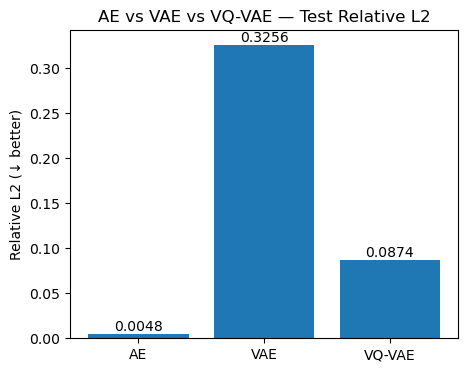

In [ ]:
# Plot Relative L2 for side-by-side comparison
labels, relL2_vals = [], []
for r in rows:
    if r["RelL2"] is not None:
        labels.append(r["Model"])
        relL2_vals.append(r["RelL2"])

plt.figure(figsize=(5,5))
plt.bar(labels, relL2_vals)  # (no explicit colors/styles)
plt.ylabel("Relative L2 (↓ better)")
plt.title("AE vs VAE vs VQ-VAE — Test Relative L2")
for i, v in enumerate(relL2_vals):
    plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")
plt.show()

In [9]:
# Show % improvement vs AE on Relative L2 (if AE available)
ae_relL2 = rows[0]["RelL2"]
if isinstance(ae_relL2, float):
    for r in rows[1:]:
        if isinstance(r["RelL2"], float):
            imp = 100.0 * (ae_relL2 - r["RelL2"]) / ae_relL2
            print(f"{r['Model']}: {imp:+.2f}% Relative L2 vs AE")
else:
    print("AE Relative L2 missing; skipping improvement calc.")

VAE: -6676.41% Relative L2 vs AE
VQ-VAE: -1719.43% Relative L2 vs AE


In [10]:
# Quick pointers to saved comparison images (worst/median/best, samples)
def list_outputs(run_dir: Path | None, prefix: str):
    if not run_dir: return []
    patterns = [f"{prefix}_test_best_pair.png", f"{prefix}_test_median_pair.png", f"{prefix}_test_worst_pair.png",
                f"{prefix}_samples*.png"]
    found = []
    for pat in patterns:
        found.extend(run_dir.glob(pat))
    return found

print("\nAE images:", [str(p) for p in list_outputs(ae_dir, "test")])  # AE uses 'test_*_pair.png'
print("VAE images:", [str(p) for p in list_outputs(vae_dir, "vae")])   # VAE uses 'vae_*'
print("VQ-VAE images:", [str(p) for p in list_outputs(vq_dir, "vqvae")])  # VQ-VAE uses 'vqvae_*'


AE images: []
VAE images: ['output\\vae_20250925_021453\\vae_test_best_pair.png', 'output\\vae_20250925_021453\\vae_test_median_pair.png', 'output\\vae_20250925_021453\\vae_test_worst_pair.png', 'output\\vae_20250925_021453\\vae_samples_prior.png']
VQ-VAE images: ['output\\vqvae_20250925_040159\\vqvae_test_best_pair.png', 'output\\vqvae_20250925_040159\\vqvae_test_median_pair.png', 'output\\vqvae_20250925_040159\\vqvae_test_worst_pair.png', 'output\\vqvae_20250925_040159\\vqvae_samples_empirical.png', 'output\\vqvae_20250925_040159\\vqvae_samples_uniform.png']
